<a href="https://colab.research.google.com/github/dasunpubudumal/deeplearning-repos/blob/main/Chapter_1_Playground_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check internet access

In [41]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

Set up the environment by installing requirements.

In [42]:
!pip install -Uqq fastai duckduckgo_search

## Download images of cats and dogs

In [43]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddgs.images(term, max_results=max_images)).itemgot('image')

Traverse through the `forest` and `bird` strings and download the images to respective directories.

In [44]:
from fastdownload import download_url
from fastai.vision.all import *

searches = 'dog','cat'
path = Path('cat_or_dog')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} running photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} in beach photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'dog running photo'
Searching for 'dog in beach photo'
Searching for 'cat photo'
Searching for 'cat running photo'
Searching for 'cat in beach photo'


Remove images with issues

In [45]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

## Train the model

We need to prepare a training set and a validation set. Alongside, we need to set up a `DataLoaders` instance in `fast.ai`.

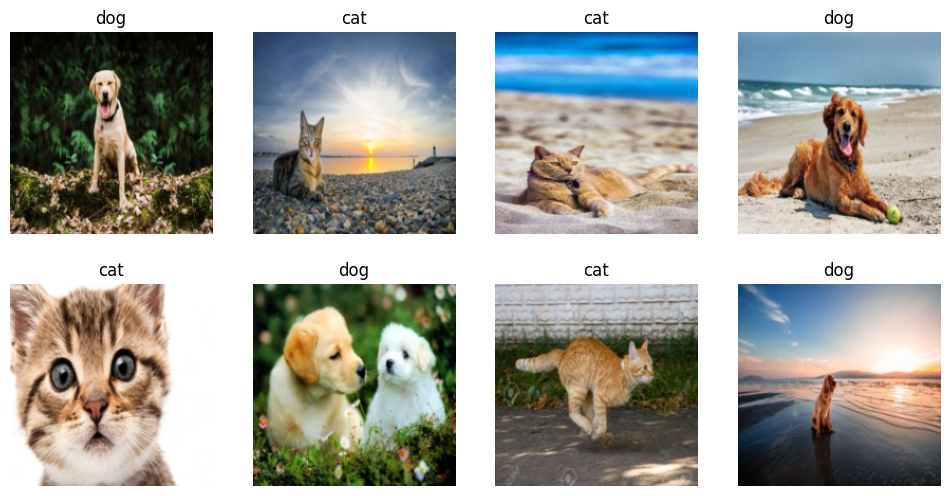

In [46]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

* `blocks`: Specifies the input block and output block
* `get_items`: Specifies the function to receive inputs
* `splitter`: Specifies the splitter for train and validation data sets
* `get_y`: Specifies where to get the training labels (and validation labels)
* `item_tfms`: Item transformations (resize by squishing the image)

Train the model. We'll take the ResNet34 model trained with millions of data, and do some transfer learning. Transfer Learning makes a model tune its parameters so that it's easy to train with a small amount of data

In [47]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 88.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.797674,0.094620,0.061538,01:27


epoch,train_loss,valid_loss,error_rate,time
0,0.212535,0.013388,0.000000,01:49
1,0.113477,0.012387,0.000000,01:48
2,0.076330,0.030044,0.030769,01:59


We'll try to predict some images.

In [63]:
import ipywidgets as widgets           # line 7
uploader = widgets.FileUpload()        # line 8
uploader

FileUpload(value={}, description='Upload')

In [68]:
def helper():        # line 9

    # plotting the image
    img = PILImage.create(uploader.data[0])
    img.show()

    # predicting the image
    label,_,probs = learn.predict(img)
    print(f"Who is this?: {label}.")
    print(f"Probability it's a dog: {probs[1].item():.6f}")

Who is this?: cat.
Probability it's a dog: 0.000088


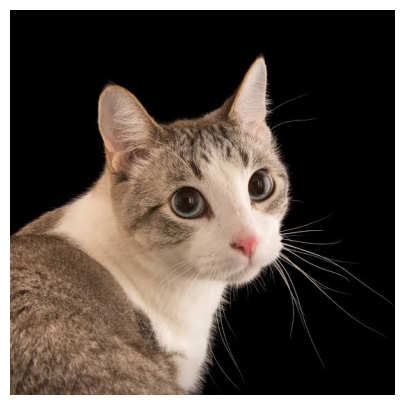

In [70]:
helper()